# Introduction and Problem Definition

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    
  <b>Overview</b>
  <p>This project aims to predict house prices based on various features describing the size, quality, and location of residential homes. It uses the Kaggle dataset <a href="https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview">House Prices - Advanced Regression Techniques</a>. While I realise a housing price regression is a rather clichéd Machine Learning task, I chose this project as it strikes a good balance between complexity and accessibility. It provides ample opportunity to demonstrate various machine learning techniques, including thorough exploratory data analysis, extensive feature engineering, hyperparameter tuning, and the use of a stacking ensemble to improve model performance.</p>

  <b>Goal</b>
  <p>The primary challenge addressed in this project is to accurately predict house prices using the 79 explanatory variables in the dataset, which include diverse features related to property size, quality, and location.</p>

  <b>Evaluation Metrics</b>
  <p>The success of the model will be measured using the Root Mean Square Error (RMSE), which provides a clear indication of how accurately the predicted house prices match the actual market prices.</p>
  
<p>Specifically, the RMSE will be calculated on the logarithm of the house prices rather than the raw sale prices, as detailed on the Kaggle competition page for this dataset. Applying a log transformation to the target variable (house prices) ensures that all errors in predictions have the same proportional impact. This approach prevents expensive homes from disproportionately impacting the model accuracy (specifically RMSE in this case). If this were not done, a house incorrectly valued at \$1.5 million instead of \$1 million would have a much larger impact than a house incorrectly valued at \$150,000 instead of \$100,000, though the relative percentage error is still 50% in both cases.</p>


  <p>This log transformation is particularly beneficial for housing price data, which can typically be skewed with a few outliers representing very expensive properties.</p>
</div>


In [1]:
# Essentials
import os
import pandas as pd
import numpy as np
import itertools
import time
import datetime 
import logging
from dataclasses import dataclass, field
from typing import Dict, Any, Optional, List, Tuple

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix 

# Stats and Optimization
import optuna
from optuna.pruners import HyperbandPruner, SuccessiveHalvingPruner, MedianPruner

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Metrics and Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

# Miscellaneous
import tqdm
from mlens.ensemble import SuperLearner
# from category_encoders import TargetEncoder, CatBoostEncoder

[MLENS] backend: threading


In [2]:
# Set the float format to display up to 5 decimal places
pd.set_option('display.float_format', '{:.5f}'.format)
# Set the Seaborn theme for plots
sns.set_theme(context='notebook', style='darkgrid')

In [3]:
def create_folder(path):
    if not os.path.isdir(path):
        os.makedirs(path)

def load_data(data_set):
    return pd.read_csv(data_set)   

In [4]:
# This code ensures that the "datasets/house_prices" directory exists.
data_folder = os.path.join("datasets", "house_prices")
create_folder(data_folder)

train_dataset = os.path.join(data_folder, 'train.csv')
test_dataset = os.path.join(data_folder, 'test.csv')

In [5]:
# Ensure the datasets are saved in the "datasets/house_prices" directory.

In [6]:
# Importing the training data only. The test dataset is loaded later to ensure no data leakage and to 
# optimise memory usage during model training.
df = pd.read_csv(train_dataset)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# Remove id column
df = df.drop(columns='Id')

# Exploratory Data Analysis

<div style="background-color: #e0ffff; padding: 10px;">
    <p>In this section, we will conduct a thorough analysis of the dataset to determine the optimal preprocessing steps for our data. Specifically, we will cover:</p>
    <ul>
        <li><strong>2.1. Data Distribution:</strong> Understanding how the features are distributed.</li>
        <li><strong>2.2. Outlier Analysis:</strong> Identifying anomalies that may influence model performance.</li>
        <li><strong>2.3. NaN Analysis:</strong> Investigating missing values in our dataset.</li>
        <li><strong>2.4. Correlation Analysis:</strong> Assessing correlations between features.</li>
    </ul>
    <p>Throughout the rest of this notebook, we will refer to this process as <strong>EDA</strong>.</p>
</div>


## Data Distribution

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
In this part of our exploratory analysis, we are testing for normality, skewness, and kurtosis. This is essential as many ML models perform poorly with skewed data. This is particularly true for linear models - which assume normality - and distance-based models like Support Vector Machines/Regression.

While tree-based (Random Forest) and boosted models (XGBoost etc) are generally more robust to the presence of skewed data and do not assume normal distributed data, they can still suffer performance loss from extreme skew as it affects model stability and interpretability. Therefore, our goal in this section is to identify any significant skewness and make appropriate transformations (e.g. logarithmic, Yeo-Johnson) to mitigate this.
    </p>
</div>

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Some of the numerical columns actually represent categories. We therefore need to remove those columns from our numerical analysis (outliers, skew etc). We will do this by designating them as a categorical datatype in order to differentiate them from actual numerical columns.

These columns are:
MSSubClass,
OverallQual and
OverallCond

In [9]:
df['MSSubClass'] = df['MSSubClass'].astype('category')
df['OverallQual'] = df['OverallQual'].astype('category')
df['OverallCond'] = df['OverallCond'].astype('category')

In [10]:
# Getting list of numerical and categorical columns from the df, this will be useful for 
# analysis purposes and for targeted preprocessing transformations in our final pipeline
numerical_columns = df.select_dtypes(include = ['int', 'float']).columns.to_list()
categorical_columns = df.select_dtypes(exclude = ['int', 'float']).columns.to_list()

In [11]:
df[numerical_columns].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1201.00000,1460.00000,1460.00000,1460.00000,1452.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,...,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000
mean,70.04996,10516.82808,1971.26781,1984.86575,103.68526,443.63973,46.54932,567.24041,1057.42945,1162.62671,...,94.24452,46.66027,21.95411,3.40959,15.06096,2.75890,43.48904,6.32192,2007.81575,180921.19589
std,24.28475,9981.26493,30.20290,20.64541,181.06621,456.09809,161.31927,441.86696,438.70532,386.58774,...,125.33879,66.25603,61.11915,29.31733,55.75742,40.17731,496.12302,2.70363,1.32810,79442.50288
min,21.00000,1300.00000,1872.00000,1950.00000,0.00000,0.00000,0.00000,0.00000,0.00000,334.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,2006.00000,34900.00000
25%,59.00000,7553.50000,1954.00000,1967.00000,0.00000,0.00000,0.00000,223.00000,795.75000,882.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,2007.00000,129975.00000
50%,69.00000,9478.50000,1973.00000,1994.00000,0.00000,383.50000,0.00000,477.50000,991.50000,1087.00000,...,0.00000,25.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,2008.00000,163000.00000
75%,80.00000,11601.50000,2000.00000,2004.00000,166.00000,712.25000,0.00000,808.00000,1298.25000,1391.25000,...,168.00000,68.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.00000,2009.00000,214000.00000
max,313.00000,215245.00000,2010.00000,2010.00000,1600.00000,5644.00000,1474.00000,2336.00000,6110.00000,4692.00000,...,857.00000,547.00000,552.00000,508.00000,480.00000,738.00000,15500.00000,12.00000,2010.00000,755000.00000


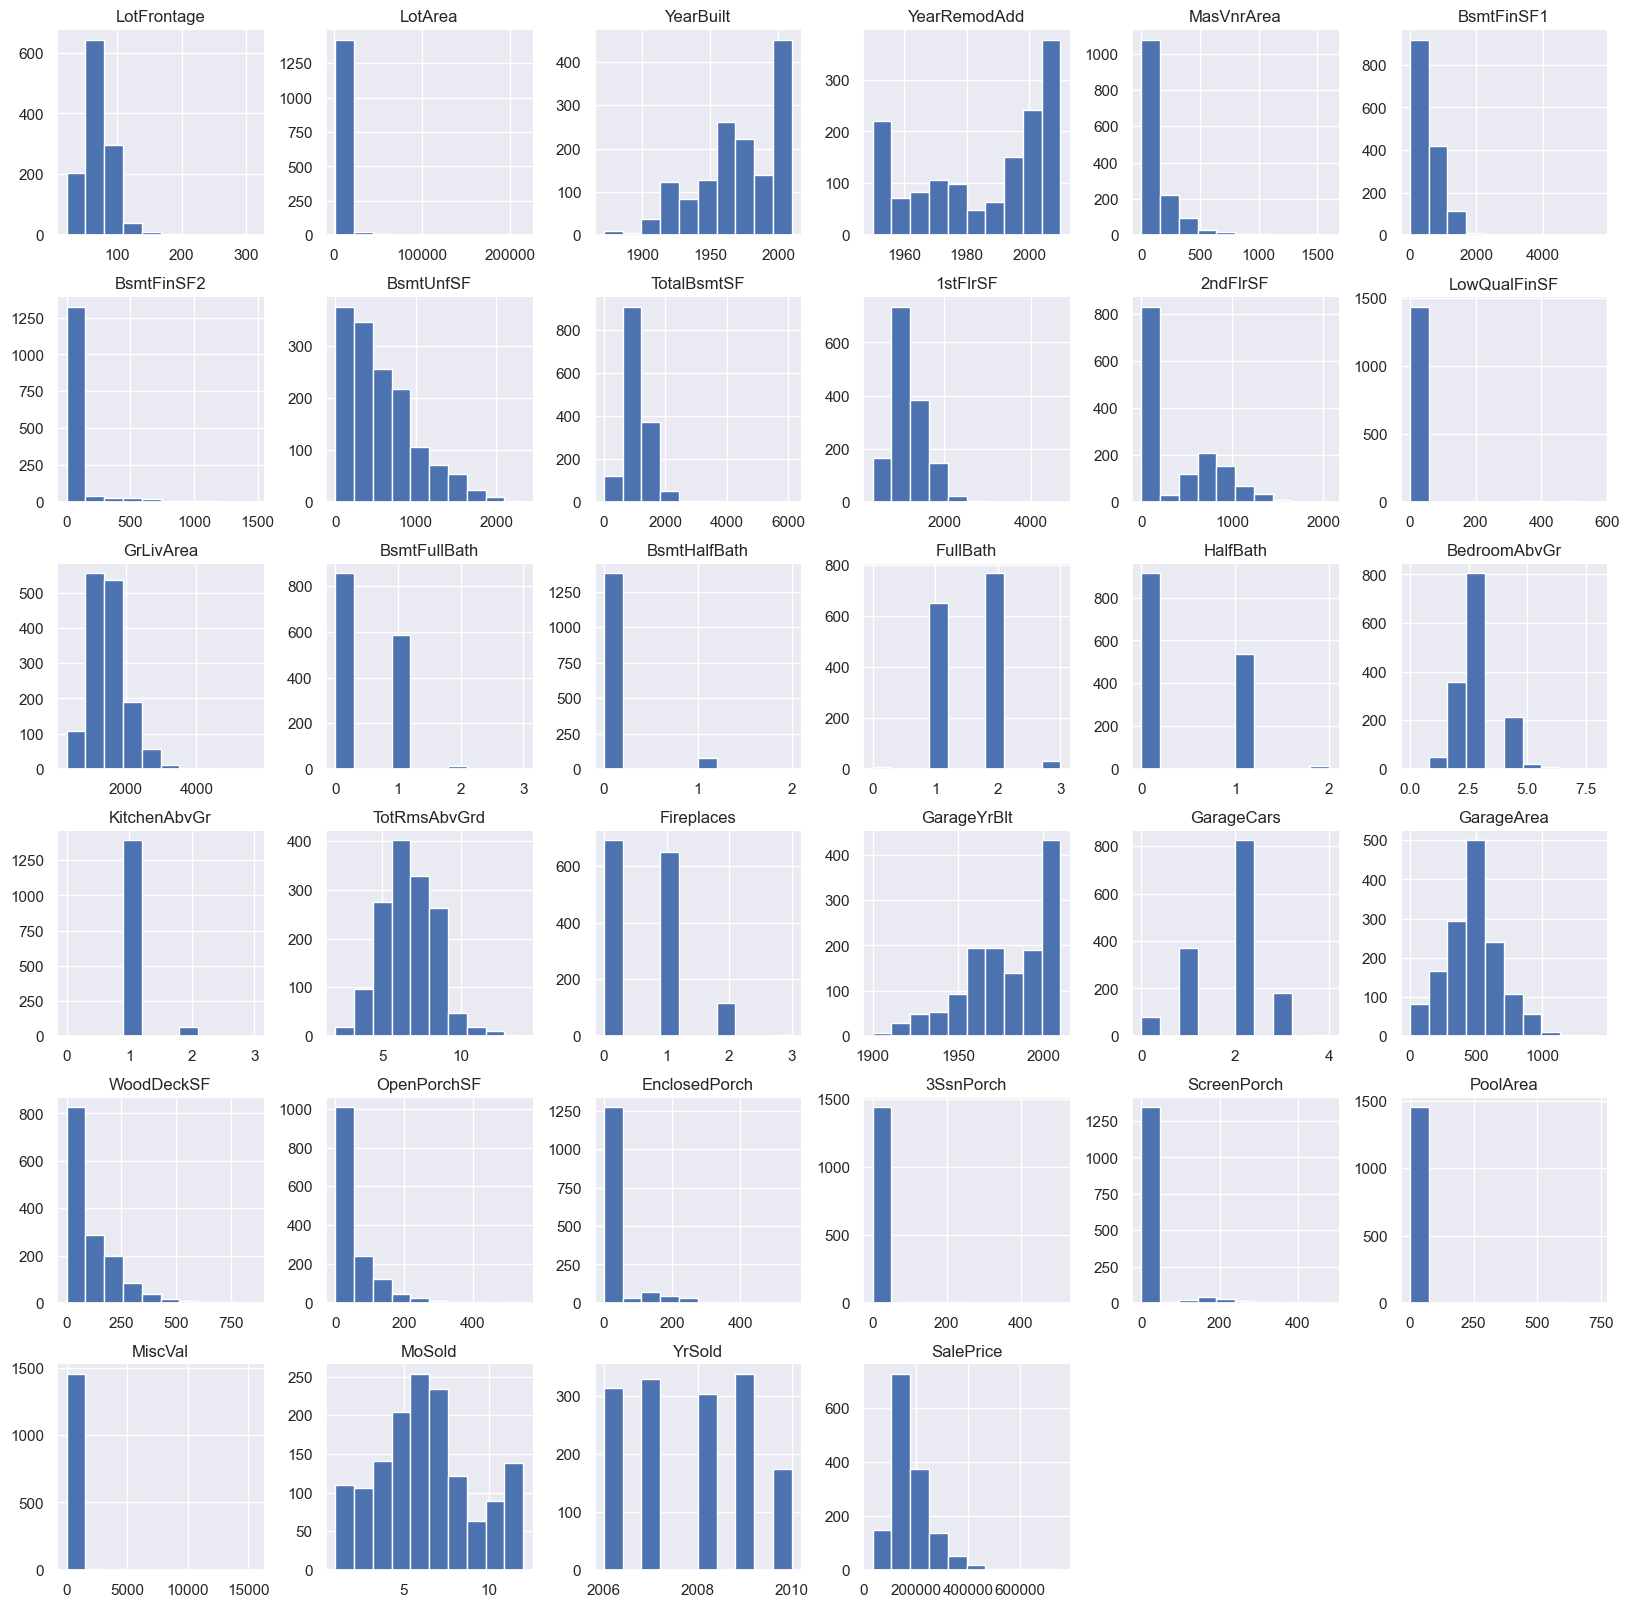

In [12]:
df[numerical_columns].hist(figsize=(20,20))
sns.despine()

In [13]:
# Looking at the ranges to determine the scales of data. Clearly, the columns have vastly 
# different ranges and will benefit from preprocessing for certain algorithms (particular SVR)
df[numerical_columns].max() - df[numerical_columns].min()

LotFrontage        292.00000
LotArea         213945.00000
YearBuilt          138.00000
YearRemodAdd        60.00000
MasVnrArea        1600.00000
BsmtFinSF1        5644.00000
BsmtFinSF2        1474.00000
BsmtUnfSF         2336.00000
TotalBsmtSF       6110.00000
1stFlrSF          4358.00000
2ndFlrSF          2065.00000
LowQualFinSF       572.00000
GrLivArea         5308.00000
BsmtFullBath         3.00000
BsmtHalfBath         2.00000
FullBath             3.00000
HalfBath             2.00000
BedroomAbvGr         8.00000
KitchenAbvGr         3.00000
TotRmsAbvGrd        12.00000
Fireplaces           3.00000
GarageYrBlt        110.00000
GarageCars           4.00000
GarageArea        1418.00000
WoodDeckSF         857.00000
OpenPorchSF        547.00000
EnclosedPorch      552.00000
3SsnPorch          508.00000
ScreenPorch        480.00000
PoolArea           738.00000
MiscVal          15500.00000
MoSold              11.00000
YrSold               4.00000
SalePrice       720100.00000
dtype: float64

Target skew: 1.8828757597682129


/Users/marcklester/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/marcklester/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


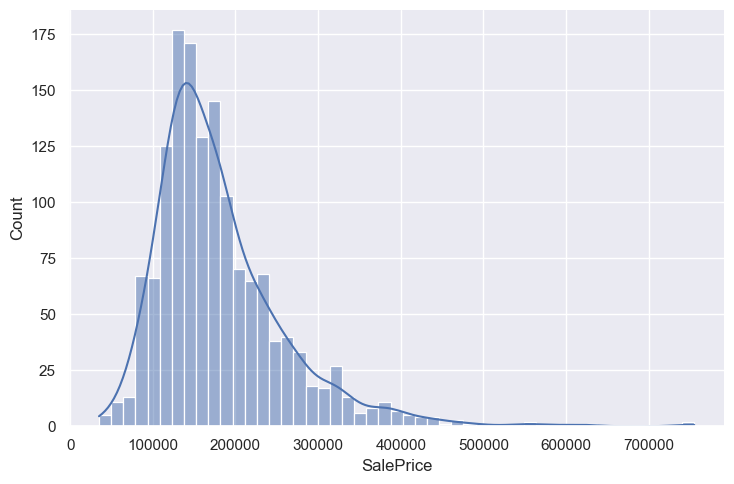

In [14]:
# As expected for housing price data, the target shows fairly significant skew. 
print(f"Target skew: {df['SalePrice'].skew()}")
sns.displot(df['SalePrice'], kde=True, height=5, aspect=1.5)
sns.despine()

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Explanation</div>
    <p>
As we predicted earlier, the housing price data is indeed skewed with several outliers representing very expensive properties.

When the target variable is skewed, as it is here, applying a log transformation to normalise it provides several benefits:

- **Standardising Error (reducing skew)**: As explained in section 1, this ensures that errors in predictions have the same proportional impact across all price ranges. In doing this, we address one of the key assumptions of linear models, namely homoscedasticity. Homoscedasticity specifies that the variance of the residuals should be constant across the dataset. By applying a log transformation to the target variable, we help standardise the residuals, thus better meeting this requirement.

- **Reduced Influence of Outliers**: Skewed data oftens contain outliers, as is the case here. These outliers can have a disproportionate effect on a model's performance. By applying a logarithmic transformation to the target variable, we effectively smooth the data, thereby reducing the extent and impact of these outliers.

- **Enhancing Model Performance**: The log transformation also allows models to better capture non-linear relationships between the features and the target. This is particularly beneficial for linear models such as Linear Regression or Ridge/Lasso, but it can also improve the performance of other models, including tree-based methods (Random Forest), distance-based algorithms (SVR), and boosted models (XGBoost etc).

Since the evaluation metric for this project is RMSE calculated on the logarithm of house prices, we will apply a log transformation to the target variable in this section. By doing this right at the start of our project, it ensures that all subsequent analysis and model training are aligned with the actual metric that will be used for evaluation.
</div>

Target skew: 0.12134661989685329


/Users/marcklester/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/marcklester/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


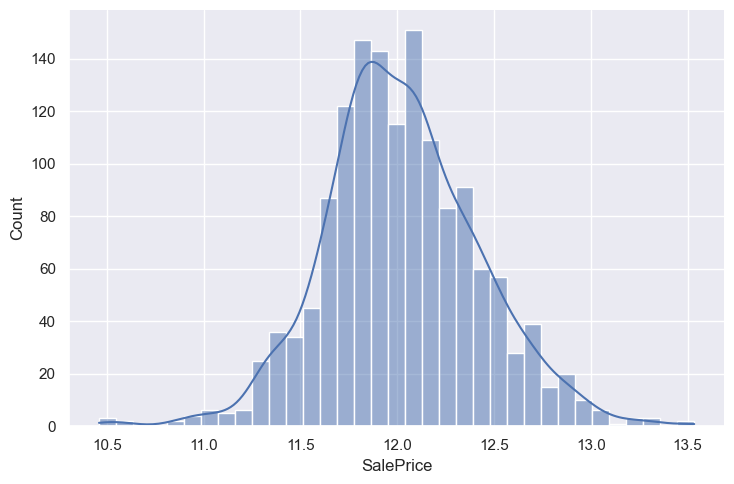

In [15]:
# We are specifically applying log(1+x) transformation intead of log(x). This is considered best practice in regression tasks 
# with skewed data because it can handle zero values. Applyling log(x) on a zero value would return undefined.

# We can observe that applying log(1+x) has significantly reduced the skew of our target variable.
df['SalePrice'] = np.log1p(df['SalePrice'])
print(f"Target skew: {df['SalePrice'].skew()}")
sns.displot(df['SalePrice'], kde=True, height=5, aspect=1.5)
sns.despine()

In [16]:
df['SalePrice']

0      12.24770
1      12.10902
2      12.31717
3      11.84940
4      12.42922
         ...   
1455   12.07255
1456   12.25487
1457   12.49313
1458   11.86447
1459   11.90159
Name: SalePrice, Length: 1460, dtype: float64

In [17]:
# For the all other numerical features, I am creating a dictionary containing each column name along with its skew. 
# This allows us to assess the impact of skewness on each numerical feature, helping to decide if any transformations 
# are needed to reduce skew in the dataset.
skew_dict = {}
for column in numerical_columns:
    skew = df[column].skew()
    skew_dict[column] = abs(skew)


data_dict = {'Column': list(skew_dict.keys()), 'Value': list(skew_dict.values())}
 
df_skew = pd.DataFrame(data_dict)
df_skew.sort_values(by='Value', ascending=False).head(15)

,Column,Value
30,MiscVal,24.47679
29,PoolArea,14.82837
1,LotArea,12.20769
27,3SsnPorch,10.30434
11,LowQualFinSF,9.01134
18,KitchenAbvGr,4.48840
6,BsmtFinSF2,4.25526
28,ScreenPorch,4.12221
14,BsmtHalfBath,4.10340
26,EnclosedPorch,3.08987


<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Summary</div>
    <p>  
As we can see, many features in the data are skewed with some extremely high skew values. This can adversely impact the performance of ML models. To address this and normalise our dataset, we plan to apply the Yeo-Johnson transformation which is not only effective for addressing negative skew, but also tweaks the level of transformation in each column depending on the level of skewness.</p>
</div>

## Outlier Analysis

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
Similar to skewed data, outliers can significantly impact ML models, particularly those that are sensitive to data distribution such as linear models and distance-based models. Therefore, effective outlier detection and handling will be crucial for improving model performance.

As we established that we are dealing with skewed data in the previous section, we will use the Interquartile Range (IQR) method to detect outliers in our data. This is more robust at dealing with non-normally distributed data.
    </p>
</div>

In [18]:
# I have created a function to detect all outliners using the IQR method.
def detect_outliers(df_column : pd.Series, q1 = 0.25, q3=0.75) -> Tuple[float, float]:
    lower_quantile = df_column.quantile(q1)
    upper_quantile = df_column.quantile(q3)
    iqr = upper_quantile - lower_quantile

    lower_bound = lower_quantile - (1.5 * iqr)
    upper_bound = upper_quantile + (1.5 * iqr)

    return lower_bound, upper_bound

outlier_columns_dict = {}
for column in df[numerical_columns]:
    lower_bound, upper_bound = detect_outliers(df[column])
    
#     Less efficient method
# outliers = df.query('@column < @lower_bound | @column > @upper_bound')

#     More efficient method using vectorised operations
    outlier_count =  ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

    if outlier_count > 0:
        outlier_columns_dict[column] = outlier_count

In [19]:
outlier_columns_dict

{'LotFrontage': 88,
 'LotArea': 69,
 'YearBuilt': 7,
 'MasVnrArea': 96,
 'BsmtFinSF1': 7,
 'BsmtFinSF2': 167,
 'BsmtUnfSF': 29,
 'TotalBsmtSF': 61,
 '1stFlrSF': 20,
 '2ndFlrSF': 2,
 'LowQualFinSF': 26,
 'GrLivArea': 31,
 'BsmtFullBath': 1,
 'BsmtHalfBath': 82,
 'BedroomAbvGr': 35,
 'KitchenAbvGr': 68,
 'TotRmsAbvGrd': 30,
 'Fireplaces': 5,
 'GarageCars': 5,
 'GarageArea': 21,
 'WoodDeckSF': 32,
 'OpenPorchSF': 77,
 'EnclosedPorch': 208,
 '3SsnPorch': 24,
 'ScreenPorch': 116,
 'PoolArea': 7,
 'MiscVal': 52,
 'SalePrice': 28}

<div style="background-color: #e0f7fa; padding: 10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Summary</div>
    <p>
As we can see, there are outliers in numerous columns of our dataset. For the purposes of this analysis, we will leave them in and address them when we apply transformations to handle the skewed data.

In a real-world project, there are several steps one could take to address these outliers:

1. **Investigate the outliers**: Investigate them to determine if they are genuine.
2. **Remove erroneous outliers**: Simply remove all outliers above a certain threshold, e.g., any outliers more than 3 standard deviations from the mean or 1.5*IQR.
3. **Replace erroneous outliers**: If the outliers are eroneous but we want to keep the data point, we can replace them with a statistical value such as the mean or median.
4. **Include outliers as a new feature**: Create a new feature with a binary value to indicate whether an outlier exists for the original feature.
5. **Transform genuine outliers**: If the outliers are genuine but we want to mitigate their influence, we could transform the data to follow a more normal distribution, e.g., apply a log transformation, Box-Cox, or Yeo-Johnson transformation.
    </p>
</div>

## NaN Analysis

<div style="background-color: #e0ffff; padding: 10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
Missing values (NaN values) in a dataset will, almost without exception, negatively impact ML models. Therefore, it is essential to ascertain the presence and extent of NaN values in a dataset and investigate the most appropriate way to handle them in a context specific manner. 

In more technical terms, we would want to determine if the NaNs are:
- **MCAR (Missing Completely At Random)**
- **MAR (Missing At Random)**
- **MNAR (Missing Not At Random)**

This classification will guide us on the appropriate technique to handle them. We will discuss these classifications when deciding the best imputation strategy for our NaNs in Section 3.2 Feature Engineering.

In this section, we perform an initial analysis of the NaN values in our dataset and assess their prevalence.
    </p>
</div>

In [20]:
# As we observed from df.info() earlier, many columns in the dataset contain NaNs.
# Let's check how prevalant the NaNs are in each column.
nan_percentages_df = (
    df.isna()
    .mean()
    .mul(100)
    .reset_index()
    .rename(columns={'index': 'Column Name', 0: 'NaN Percentage'})
    .sort_values(by='NaN Percentage', ascending=False)
)

nan_percentages_df.head(10)

,Column Name,NaN Percentage
71,PoolQC,99.52055
73,MiscFeature,96.30137
5,Alley,93.76712
72,Fence,80.75342
24,MasVnrType,59.72603
56,FireplaceQu,47.26027
2,LotFrontage,17.73973
58,GarageYrBlt,5.54795
63,GarageCond,5.54795
57,GarageType,5.54795


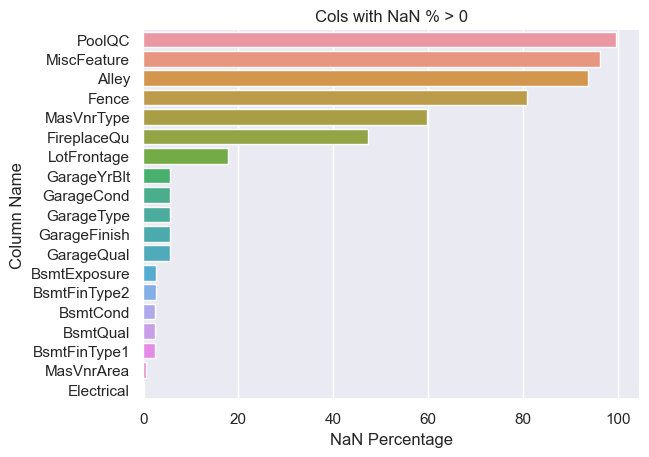

In [21]:
# Plot NaN percentages by column
sns.barplot(data=nan_percentages_df.query('`NaN Percentage` > 0'), x='NaN Percentage', y='Column Name')
plt.title('Cols with NaN % > 0')
sns.despine()

In [22]:
# The following columns contain NaNs and their datatype
nan_columns = df.columns[df.isna().any()]
df[nan_columns].dtypes

LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscFeature      object
dtype: object

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Summary</div>
    <p>
As observed, our dataset contains a significant number of missing values, particularly in numerous categorical columns. Therefore, it is essential that we devise robust and tailored strategies for handling them.

In Section 3.2 Feature Engineering, we will explore the best strategies for handling these NaNs based on their context.
    </p>
</div>

## Correlation

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
In this section, we will explore the presence of high correlation and multicollinearity between our model features. High correlation between features can lead to several issues, including:

- **Model instability**
- **Overfitting**
- **Redundancy in information**
- **Interpretation difficulties**

As before, some models are affected by high correlation more severely than others. This is particularly true for linear models, whereas tree-based and distance-based models tend to be more robust at handling correlated data. That being said, even they can be affected if the correlation is extremely high.
    </p>
</div>

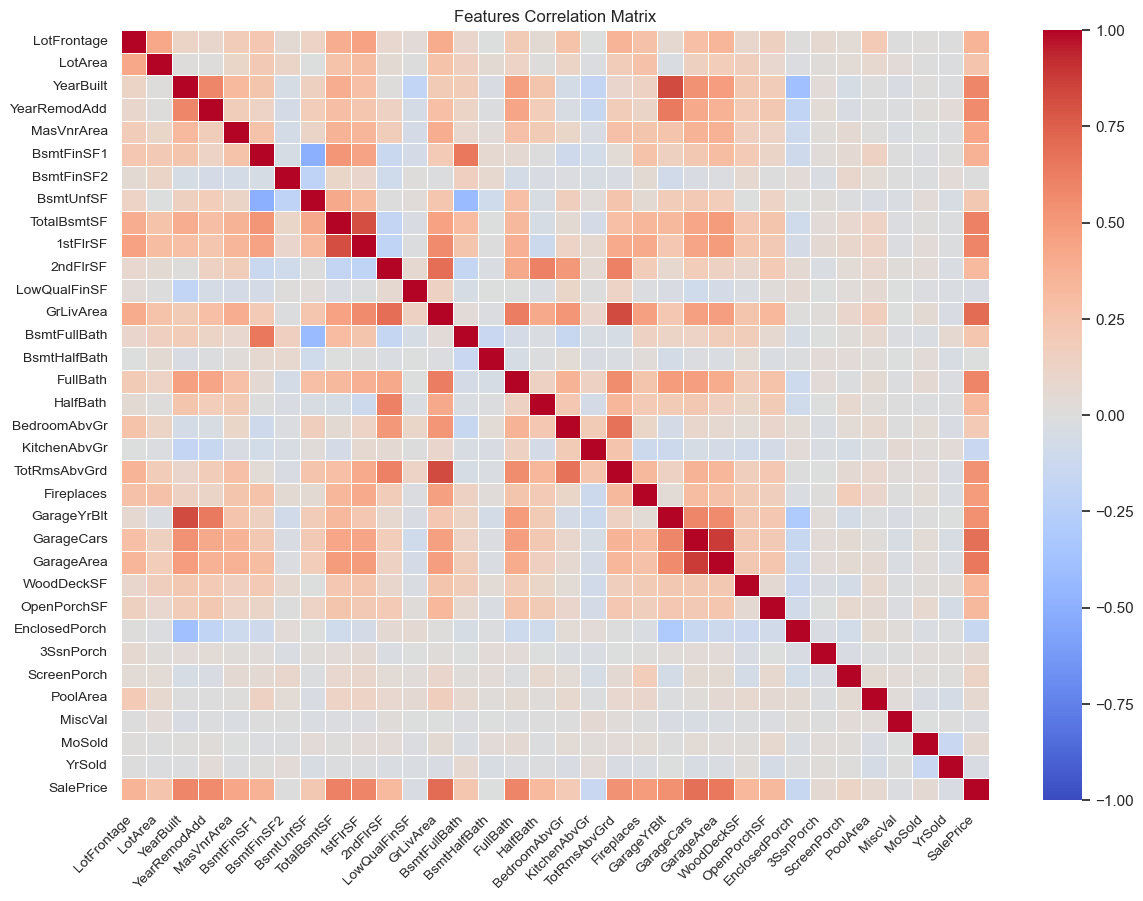

In [23]:
# View correlation matrix heatmap
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
heatmap = sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

# Rotate the column and row labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Features Correlation Matrix')
plt.show()

Our correlation heatmap shows there are several clusters of highly correlated features (e.g. look at the top LHS). There are also a few strong negative correlations present in the data.

In [24]:
# Now let's look at which features are most highly correlated with the target 
correlation_matrix = df[numerical_columns].corr()
correlation_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.00000
GrLivArea        0.70093
GarageCars       0.68062
GarageArea       0.65089
TotalBsmtSF      0.61213
1stFlrSF         0.59698
FullBath         0.59477
YearBuilt        0.58657
YearRemodAdd     0.56561
GarageYrBlt      0.54107
TotRmsAbvGrd     0.53442
Fireplaces       0.48945
MasVnrArea       0.43081
BsmtFinSF1       0.37202
LotFrontage      0.35588
WoodDeckSF       0.33414
OpenPorchSF      0.32105
2ndFlrSF         0.31930
HalfBath         0.31398
LotArea          0.25732
BsmtFullBath     0.23622
BsmtUnfSF        0.22199
BedroomAbvGr     0.20904
ScreenPorch      0.12121
PoolArea         0.06980
MoSold           0.05733
3SsnPorch        0.05490
BsmtFinSF2       0.00483
BsmtHalfBath    -0.00515
MiscVal         -0.02002
YrSold          -0.03726
LowQualFinSF    -0.03796
KitchenAbvGr    -0.14755
EnclosedPorch   -0.14905
Name: SalePrice, dtype: float64

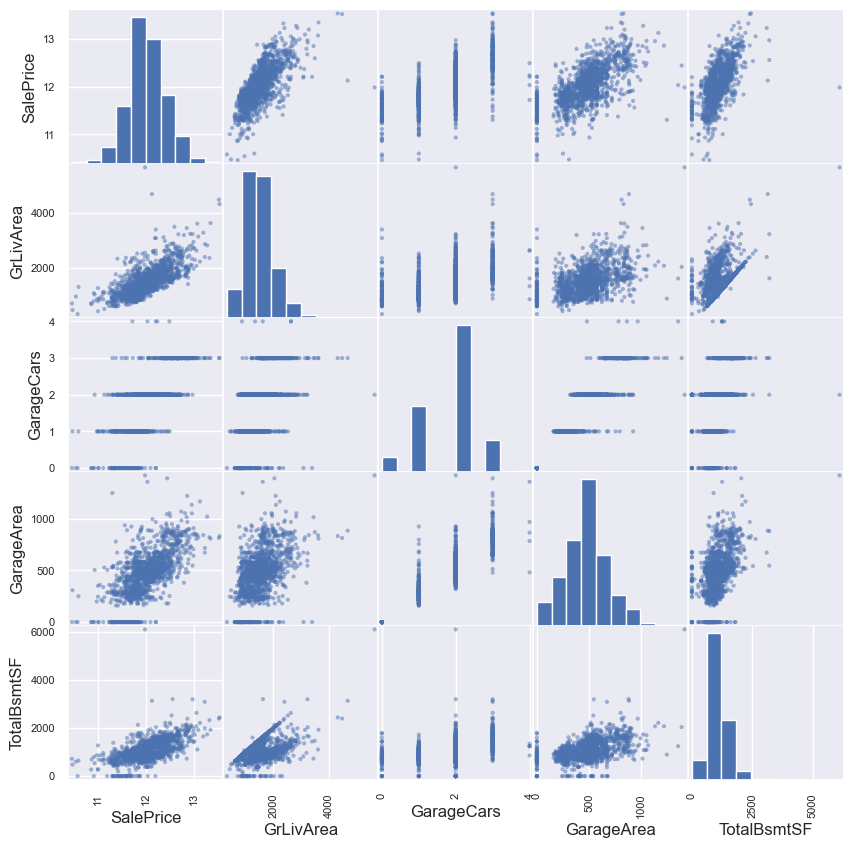

In [25]:
# Anaylsing top 5 features most highly correlated with the target
highly_correlated = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']

scatter_matrix(df[highly_correlated], figsize=(10,10))
sns.despine()

/Users/marcklester/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


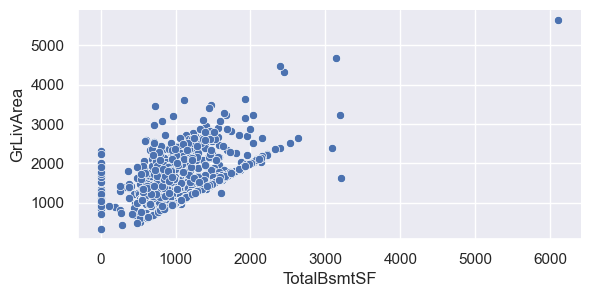

In [26]:
sns.pairplot(df, x_vars='TotalBsmtSF', y_vars ='GrLivArea', height=3, aspect=2)
sns.despine()

There is a suspicious relationship here between the TotalBsmtSF and GrLivArea feature plotted above, especially 
with the near perfect correlation shown by the straight diagonal line. 
There are also some clear outliers in this data.

Given the high correlation of these features with the target, in a production environment
further investigation would be necessary to determine whether this relationship 
is genuine or if there were any data collection issues etc.

/Users/marcklester/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


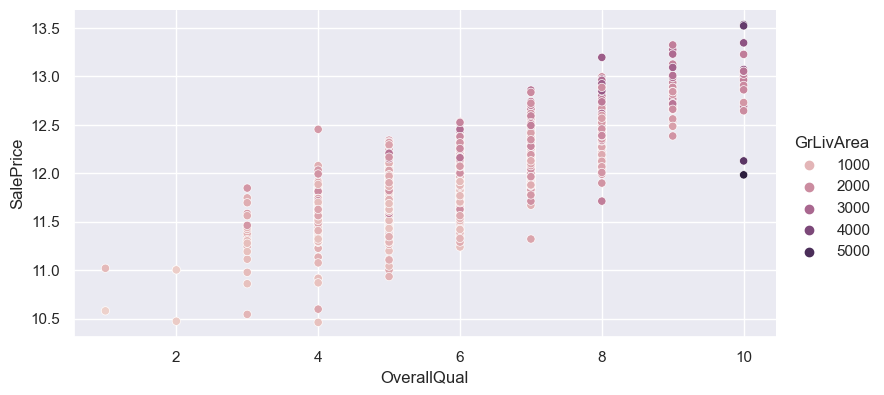

In [27]:
# SalePrice is most highly correlated with OverallQual and GrLivArea, so we plot these relationships
sns.pairplot(df, x_vars='OverallQual', y_vars ='SalePrice', hue='GrLivArea', height=4, aspect=2)
sns.despine()

As expected, the plot shows that SalePrice has a strong positive correlation with both Overall Quality (OverallQual) and Above Grade Living Area (GrLivArea).

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Summary</div>
    <p>
For highly correlated features, there are several possible mitigation techniques. These include:

- **Dropping Highly Correlated Features**: Removing redundant variables to simplify the model.
- **Dimensionality Reduction**: Employing techniques such as Principal Component Analysis (PCA) to reduce the number of variables while retaining essential information.
- **Regularization**: Implementing methods such as Lasso or Ridge to reduce the coefficients of correlated predictors.
- **Variance Inflation Factor (VIF)**: Using VIF to detect multicollinearity and dropping features with a VIF value above a threshold.

In our dataset, given the high level of correlation between multiple features as shown in our heatmap, I will experiment with applying PCA and Regularisation to my dataset to see how it impacts the efficacy of the model.
            </p>
</div>

# Preprocessing

<div style="background-color: #e0ffff; padding: 20px;">
    <p>In this section, we will build upon the insights from the EDA section to determine the most appropriate preprocessing techniques for our dataset. To avoid data leakage, all preprocessing steps will be applied solely to the training data, ensuring that no information from the test set inadvertently influences any transformations applied to the features.</p>
    <p>We will cover the following:</p>
    <ul>
        <li><strong>3.1. Data Cleaning:</strong> Removing inconsistencies and handling missing data.</li>
        <li><strong>3.2. Feature Engineering:</strong> Creating new meaningful features to improve model performance.</li>
        <li><strong>3.3. Encoding:</strong> Converting categorical variables to numerical format.</li>
        <li><strong>3.4. Scaling:</strong> Standardizing or normalizing numerical features.</li>
        <li><strong>3.5. Principal Component Analysis (PCA):</strong> Reducing dimensionality for efficiency.</li>
        <li><strong>3.6. Final Preprocessing Pipeline:</strong> Putting all steps together into a complete preprocessing pipeline.</li>
    </ul>
</div>


## Data Cleaning

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
In this section, we will address data quality issues by identifying and handling duplicates (if any) and managing the outliers detected during the EDA.

As we discovered, there are numerous and significant outliers in our dataset. We will address them accordingly by using the **Interquartile Range (IQR) method** to detect outliers, as it is robust to skewed data. Once outliers are identified, we will transform them as needed.

To handle the outliers in a scalable and flexible manner, allowing us to easily reproduce these transformations on new data and tweak them, I have created a custom `OutlierHandler` class. This approach will also help build a library of transformations that can be reused in future projects.
    </p>
</div>

In [28]:
# Split data into training set and target
X, y = df.drop(columns=['SalePrice'], axis=1), df['SalePrice']

In [29]:
# Removing the target from our analysis
numerical_columns.remove('SalePrice')

In [30]:
# There are no duplicated rows in our dataset so nothing further needs to be done here.
df.duplicated().sum()

0

In [31]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    """
    A custom transformer for detecting and handling outliers in a DataFrame or NumPy array.

    This transformer identifies outliers based on the interquartile range (IQR) and offers various strategies
    to handle them, such as replacing outliers with the mean, median, or capping/flooring them to the outlier boundaries.

    Parameters
    ----------
    q1 : float, optional
        Lower quantile for calculating the IQR, by default 0.25.
    q3 : float, optional
        Upper quantile for calculating the IQR, by default 0.75.
    outlier_boundary : float, optional
        Multiplier for the IQR to determine the outlier boundaries, by default 1.5.
    method : str, optional
        Method to handle outliers. Options are 'mean', 'median', or 'cap/floor', by default 'mean'.
  
  
    Methods
    -------
    fit(X, y=None)
        No fitting is performed; returns self.
    transform(X)
        Applies the outlier handling transformation to the input data.
    get_replacement_values(col, lower_bound, upper_bound)
        Determines the replacement values for outliers based on the selected method.
    process_column(col)
        Processes a single column to handle outliers according to the specified method.
    """

    def __init__(self, q1: float = 0.25, q3: float = 0.75, outlier_boundary: float = 1.5, 
                 method: str = 'mean'):
        self.q1 = q1
        self.q3 = q3
        self.outlier_boundary = outlier_boundary
        self.method = method

    def fit(self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray = None):
        """
        Fit the transformer. This method does not perform any fitting as it is a stateless transformer.

        Returns
        -------
        OutlierHandler
            Returns the instance itself.
        """
        return self

    def transform(self, X: pd.DataFrame | np.ndarray) -> pd.DataFrame | np.ndarray:
        """
        Transform the data by detecting and handling outliers based on the specified method.

        Parameters
        ----------
        X : pd.DataFrame or np.ndarray
            Input data to transform.

        Returns
        -------
        pd.DataFrame or np.ndarray
            Transformed data with outliers handled.
        """
        is_array = isinstance(X, np.ndarray)
        X = pd.DataFrame(X) if is_array else X.copy()
        
        # Apply the outlier handling method to each column
        X = X.apply(self.process_column)
        
        # Convert back to a NumPy array if the original input was an array
        return X.to_numpy() if is_array else X

    def get_replacement_values(self, col: pd.Series, lower_bound: float, upper_bound: float) -> tuple:
        """
        Get the replacement values for outliers based on the selected method.
        
        This is a dedicated method for handling the replacement of outliers. Centralising this logic
        makes the code more maintainable and allows for easy extension with new, customised outlier handling strategies.
        
        Parameters
        ----------
        col : pd.Series
            The column being processed.
        lower_bound : float
            The calculated lower bound for outliers.
        upper_bound : float
            The calculated upper bound for outliers.
            
        Returns
        -------
        tuple
            A tuple containing the replacement values for lower and upper outliers.
            
        Raises
        ------
        ValueError
            If an unsupported method is specified.
        """
        if self.method == 'mean':
            value = col.mean()
            return value, value
        elif self.method == 'median':
            value = col.median()
            return value, value
        elif self.method == 'cap/floor':
            return lower_bound, upper_bound
        else:
            raise ValueError(f"Method '{self.method}' is not supported. Choose from ['mean', 'median', 'cap/floor'].")

    def process_column(self, col: pd.Series) -> pd.Series:
        """
        Process a column to detect and handle outliers according to the specified method.

        Parameters
        ----------
        col : pd.Series
            The column to be processed.

        Returns
        -------
        pd.Series
            The column with outliers handled.
        """
        lower_quantile, upper_quantile = col.quantile([self.q1, self.q3])
        iqr = upper_quantile - lower_quantile
        spread = self.outlier_boundary * iqr
        lower_bound, upper_bound = lower_quantile - spread, upper_quantile + spread

        # Ensure the lower bound is non-negative
        lower_bound = max(0, lower_bound)
 
        lower_bound_replacement, upper_bound_replacement = self.get_replacement_values(col, lower_bound, upper_bound)    

        # Replace outliers with the appropriate values
        col.loc[col < lower_bound] = lower_bound_replacement
        col.loc[col > upper_bound] = upper_bound_replacement
        
        return col


## Feature Engineering

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
        As described in the book <b>"Designing Machine Learning Systems"</b> by Chip Huyen, feature engineering is arguably the single most impactful step in improving model performance. The book also references an interesting 2014 paper by Facebook, <a href="https://research.facebook.com/publications/practical-lessons-from-predicting-clicks-on-ads-at-facebook/">Practical Lessons from Predicting Clicks on Ads at Facebook</a>, which emphasises this point.
    </p>
    <p>
        In this section, we could explore feature engineering in great detail and spend an inordinate amount of time on it. However, for the sake of efficiency, we will perform some initial feature engineering without dedicating too much time at this stage.
    </p>
</div>

In this first part, we will analyse how best to impute the the significant prevalence of NaN values in our data.

In [32]:
# Listing all the columns and their datatypes in our data that contain NaNs.
nan_columns = X.columns[X.isna().any()]
X[nan_columns].dtypes

LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscFeature      object
dtype: object

In [33]:
# Deriving the numerical coloumns containing NaNs for imputation
numerical_nan_columns = df[nan_columns].select_dtypes(include=['number']).columns
numerical_nan_columns

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [34]:
# Deriving the categorical coloumns containing NaNs for imputation
categorical_nan_columns = df[nan_columns].select_dtypes(exclude=['number']).columns
categorical_nan_columns

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [35]:
# Now, we will check if all NaNs in the GarageType column are valid and merely indicate the 
# absence of a garage. Therefore, for every NaN in GarageType, the other corresponding 
# Garage columns should also contains NaNs. 

# We can see from the below, that this is the case.
X[X['GarageType'].isna()][['GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']].isna().all()

GarageYrBlt     True
GarageFinish    True
GarageQual      True
GarageCond      True
dtype: bool

In [36]:
# Similar to before, for every NaN in GarageType, the other corresponding numerical Garage columns should contains zeros. 
# We can see from the below, that this is the case.
X[X['GarageType'].isna()][['GarageCars', 'GarageArea']].sum()

GarageCars    0
GarageArea    0
dtype: int64

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    
  <b>Handling MNAR (Missing Not At Random) NaNs</b>
  <p>Similar to the Garage features, analysis shows that NaNs in the 'Fireplace', 'Basement', 'Pool' and 'MasonryVeneer' columns are accurate and indicate the absence of these features. For instance, a NaN in the 'Pool' column signifies that the house does not have a pool.

Therefore, for these categorical columns, we will impute NaNs with 'None' to represent its absence. Given that many categorical columns contain NaNs, we will automate this process using an imputer as part of the preprocessing pipeline in section 3.6. This approach is suitable for these features since they fall under the MNAR classification, meaning the missing data is directly related to the actual value that would have been observed.

As well as imputing the missing values for these features with 'None', we also need to preserve the original meaning and ordinality of the feature (e.g. Garage Quality). To achieve this, we will add a new binary feature to indicate the presence of that feature. For example, instead of including 'No Garage' as a category in the ordinal 'Garage Quality' feature, we will create a new binary 'Garage Present' feature.</p>

  <b>Handling MAR (Missing At Random) NaNs</b>
  <p>For some features, such as the <strong>Functional</strong> feature, the data description suggests that missing values are not completely random but may be related to other observable factors in the dataset, thus fitting the Missing at Random (MAR) classification. For instance, the description for the <strong>Functional</strong> feature states: "Functional: Home functionality (Assume 'typical' unless deductions are warranted)." This implies that missing values for this feature may be due the overall condition of the home and not the actual feature itself.


      
Given this, we will apply a tailored imputation strategy for these features. Specifically, for the <strong>Functional</strong> feature, we will impute missing values with 'Typ', which represents the typical value for this feature.</p>

  <b>Handling MCAR (Missing Completely At Random) NaNs</b>
  <p>For the other categorical columns where a NaN neither indicates the absence of the feature nor is related to other features in the dataset, we will impute NaNs with the mode value. These features most likely fall under the MCAR classification, meaning the absence of data is truly random and not related to any other features in the dataset. Therefore, imputing with the mode value in this case is a simple yet robust approach, as the missing value likely represents an unknown or unreported value. This preserves the integrity of the feature without losing data points or introducing unnecessary categories or assumptions.</p>

</div>


In this next part, I will handle feature creation and custom imputation.

In [37]:
# Below, I have created a custom feature engineering class. 
# By doing this in one class rather than in step-by-step code (procedural code), it is easier to maintain, 
# adjust, and scale. It also integrates well into the pipeline, ensuring consistency and future-proofing 
# when applying the same transformations to new data.

class CustomFeatureEngineering(BaseEstimator, TransformerMixin):
    """
    A custom feature engineering class that handles multiple preprocessing tasks.
    This class is designed to maintain an organized and scalable pipeline, integrating
    tasks such as imputation, creation of new features, and categorical data handling.
    """
    def fit(self, X, y=None):
        # Fit method for compatibility; doesn't need to learn anything
        return self
    
    def transform(self, X):
        """
        Apply transformations to the DataFrame, including filling missing values,
        creating new features, and handling categorical features where NaN indicates
        absence.
        """
        X = X.copy()
        
        # Fill missing 'LotFrontage' based on neighborhood average. After experimentation, I found this to give
        # better results than imputing with the median value.
        X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

        # Add features to capture the age of the house and time since last remodel
        current_year = datetime.datetime.now().year
        X['Age_Since_Built'] = current_year - X['YearBuilt']
        X['Years_Since_Remodel'] = current_year - X['YearRemodAdd']

        # Create comprehensive measures of square footage and bathrooms
        X['Total_SF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
        X['Total_Finished_SF'] = X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['1stFlrSF'] + X['2ndFlrSF']
        X['Total_Bathrooms'] = (X['FullBath'] + (0.5 * X['HalfBath']) +
                                X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))
        X['Total_Porch_SF'] = (X['OpenPorchSF'] + X['3SsnPorch'] +
                               X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF'])
        
        # For the Masonry Veneer binary column, we can see from the data description that None is also a possible value.
        # Therefore, will create the binary feature based on whether the MasVnrType contains a NaN or 'None' value.
        X['Has_MasVnr'] = X['MasVnrType'].apply(lambda x: 1 if pd.isna(x) or x == 'None' else 0)
        
        # # List of columns to impute with 'NA' as we know NaNs indicate the absence of this feature
        nan_columns = [
            'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
            'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
            'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
        ]
        X[nan_columns] = X[nan_columns].fillna('NA')

        # Impute 'MasVnrArea' and 'GarageYrBlt' with 0 as we know NaN indicates absence of that feature
        X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
        X['GarageYrBlt'] = X['GarageYrBlt'].fillna(0)

        return X


In [38]:
# Defining new numerical columns produced by the CustomFeatureEngineering class that still require preprocessing
new_num_columns = ['Age_Since_Built', 
                   'Years_Since_Remodel', 
                   'Total_SF', 
                   'Total_Finished_SF', 
                   'Total_Bathrooms', 
                   'Total_Porch_SF']

# Check if the first new column is already in the list to avoid duplicates
if new_num_columns[0] not in numerical_columns:
    numerical_columns.extend(new_num_columns)

# Now the numerical_columns list will include all new numerical columns correctly for preprocessing

In [39]:
# This class creates binary features that indicate the presence of missing values (NaNs) in specified columns.
# Similar to the Custom Feature Engineering class, it allows for scalability and future-proofing by automating 
# the handling of missing data in a consistent way.
class CreateBinaryFeature(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list[str]):
        self.columns = columns

    def fit(self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray = None):
        return self

    def transform(self, X: pd.DataFrame | np.ndarray) -> pd.DataFrame | np.ndarray:
        is_array = isinstance(X, np.ndarray)
        X = pd.DataFrame(X) if is_array else X.copy()
        
        # Ensure the columns exist in the DataFrame
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f"Columns {missing_cols} not found in the input data.")
        
        # Create binary columns using vectorisd operations for efficiency
        for col in self.columns:
            X[f"Binary_{col}"] = X[col].isna().astype(int)

        # Convert back to a NumPy array if the original input was an array
        return X.to_numpy() if is_array else X
    


<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 18px; font-weight: 600;">Summary</div>
    <p>
In this section, I created several new features to enhance model performance and investigated the best imputation methods for handling NaNs based on their specific context.

If we wanted to spend more time in this section, we could try additional feature engineering techniques, such as:

- **Squaring features** to capture non-linear relationships.
- **Removing low-variance features** to reduce noise.
- **Feature crossing** to capture interactions between features.
    </p>
</div>

## Encoding

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
In this section, we focus on transforming categorical data into numerical format, making them interpretable for ML models. Most ML models, except CatBoost, cannot effectively handle categorical features directly. Therefore, selecting the appropriate encoding techniques for our data is essential.

For ordinal categories, I’ve chosen to use an **OrdinalEncoder** to preserve the natural order of the data and maintain its meaning (e.g., Poor, Average, Good, etc.).

For nominal categories, I will use **OneHotEncoder**, which increases the number of features by creating a new binary column for each category. This approach can potentially inflate the size of the dataset significantly, thereby impacting efficiency. However, since the number of categories and their cardinality (the number of unique values in each category) are relatively small in this dataset, the increase in features should not lead to performance issues.

I initially experimented with using **CatBoost encoding** for high cardinality features (those with more than 10 unique values), as CatBoost is more memory-efficient than OneHotEncoding and can preserve relationships well between categories and the target variable. However, after testing, OneHotEncoding for high cardinality features actually resulted in slightly better performance without any noticeable impact on efficiency.

Lastly, using CatBoost encoding introduced some issues, particularly with cross-validation in Sklearn (e.g., specifically using `cross_val_score`), as it alters the indices of the dataset, causing errors. Therefore, this made OneHotEncoding the obvious choice for nominal categories.
    </p>
</div>

Encoding methods detailed below:

- **Ordinal categories**: Ordinal Encoding
- **Nominal categories (<10 unique features)**: One-Hot Encoding
- **Nominal categories (>=10 unique features)**: One-Hot Encoding

In [40]:
# Discerning between the ordinal and nominal (unordered) categories. We are doing this to ensure the correct 
# encoding technique is applied to those categories.

# OverallQual and OverallCond are already represented by numbers in a meaningful order, 
# therefore encoding is unnecessary.

ordinal_categories = [
    'LotShape', 
    'LandSlope',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu',
    'GarageQual',
    'GarageCond',
    'PoolQC'
]

nominal_categories = [column for column in categorical_columns if column not in ordinal_categories]
print(nominal_categories)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [41]:
# Ordered categories for each ordinal feature. This ensures that the ordinal relationship 
# between the categories is preserved when they are encoded.
categories = [
    ['Reg', 'IR1', 'IR2', 'IR3'],  # LotShape
    ['Gtl', 'Mod', 'Sev'],  # LandSlope
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # ExterQual
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # ExterCond
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # BsmtQual
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # BsmtCond
    ['NA', 'No', 'Mn', 'Av', 'Gd'],  # BsmtExposure
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # HeatingQC
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # KitchenQual
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # FireplaceQu
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # GarageQual
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # GarageCond
    ['NA', 'Fa', 'TA', 'Gd', 'Ex'],  # PoolQC
    # ['Tiny', 'Small', 'Medium', 'Large', 'Very Large']
]

In [42]:
low_cardinality_categories = [feature for feature in nominal_categories if df[feature].nunique()<10]
high_cardinality_categories = [feature for feature in nominal_categories if df[feature].nunique()>=10]

In [43]:
ordinal_encoder = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1)
onehot_encoder = OneHotEncoder(handle_unknown = 'ignore')
# cbe = CatBoostEncoder(cols=high_cardinality_categories, random_state=42)

## Scaling

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
Similar to what was discussed in the sections on skewed data and outliers, differing feature scales can negatively impact ML models, particularly linear and distance-based models. As these models are sensitive to the size of feature values, applying feature scaling is important to avoid the disproportionate influence from features with larger scales.

Although each scaling technique has its own pros and cons, as we have a relatively small dataset, we are able to experiment with different methods to determine which most benefits our ML algorithm. For example, **MinMaxScaler** is more sensitive to outliers as it scales each feature to a specific range, typically (0,1).

Specifically, we will test the performance improvement by applying the following scaling techniques:

1. **StandardScaler**
2. **MinMaxScaler**
3. **RobustScaler**

These scaling methods will be implemented in the `NumericalTransformer` class as part of the Final Preprocessing Pipeline in section 3.6.
    </p>
</div>

## Principle Component Analysis

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
During the EDA, we identified multiple correlated factors within our dataset. To address this, we will experiment with applying Principal Component Analysis (PCA). This should provide the following benefits:

- **Reducing Dimensionality**: High-dimensional datasets are prone to overfitting—this is the curse of dimensionality! By applying PCA, we should be able to significantly reduce the dimensionality of our dataset.

- **Improving Computational Efficiency**: By applying PCA, we can significantly reduce the size of our dataset, speeding up the processing time needed to apply and test different preprocessing techniques and various machine learning algorithms. Moreover, this will also make the process of fine-tuning our final model much quicker if we decide to go down this route.

- **Removing Multicollinearity**: As our heatmap showed high correlation between multiple features, applying PCA can transform our dataset into a set of uncorrelated components. This helps mitigate the adverse impact high correlation can have on a model, thereby improving its accuracy.

Of course, we do not have to use PCA for dimensionality reduction. There are indeed other techniques that may be more suitable for non-linear data. However, for the sake of simplicity and considering that PCA is the most popular dimensionality reduction algorithm, we will test it on our dataset.

We will implement PCA in the `NumericalTransformer` class as part of the Final Preprocessing Pipeline in section 3.6.
    </p>
</div>

## Final Preprocessing Pipeline

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
        In this section, we will integrate all preprocessing steps into a robust, customisable, and scalable pipeline. This final preprocessing pipeline is designed to address various key aspects of our dataset effectively. This includes:

- **Handling Missing Values**
- **Outlier Detection and Handling**
- **Feature Engineering**
- **Feature Scaling**
- **Addressing Data Skew (using Yeo-Johnson transformation)**
- **Categorical Encoding**

The preprocessing pipeline contains the following custom classes:

- **OutlierHandler** - A custom transformer for detecting and handling outliers with adjustable parameters and outlier handing methods.
- **CustomFeatureEngineering** - A custom feature engineering class that handles multiple preprocessing tasks specific to this dataset, including custom imputation and feature creation.
- **CreateBinaryFeature** - A custom class that creates binary features that indicate the presence of missing values (NaNs) in specified columns.
- **NumericalTransformer (created below)** - A specialised class to enable easy building and tweaking of customisable pipeline for preprocessing numerical features.

I have decided to use classes in the preprocessing pipeline as they provide several key benefits over procedural (step-by-step) code. They enhance modularity and maintainability, making it easier to apply updates and adjustments. By using classes, we also allow our code to be scalable and reusable for new data and even for new projects. Lastly, they integrate seamlessly with ML pipelines, which ensures we will always be applying the same transformations to both training and new data.
    </p>
</div>

In [44]:
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
categorical_imputer = SimpleImputer(strategy='constant', fill_value='NA')

In [45]:
@dataclass
class BaseTransformer(BaseEstimator, TransformerMixin):
    """
    A base class for customizable transformers that build scikit-learn pipelines.

    This class provides a foundation for creating transformers that can be easily extended and customized
    by defining pipeline steps in subclasses. It also includes optional logging and parameter validation functionality.

    Attributes
    ----------
    params : Dict[str, Any]
        A dictionary of parameters that configure the transformer behavior.
    logger : Optional[logging.Logger]
        An optional logger instance used for recording information, warnings, or errors during the transformer's operations.
        If no logger is provided upon instantiation, a default logger is created with a NullHandler.
        This allows for the optional configuration of custom logging handlers and ensures 
        that no errors occur if no logger is specified.
    """

    params: Dict[str, Any] = field(default_factory=dict)
    logger: Optional[logging.Logger] = None

    def __post_init__(self):
        """
        Initialise the BaseTransformer instance.

        This method ensures that a logger is configured and validates the parameters provided during instantiation.
        """
        if self.logger is None:
            self.logger = logging.getLogger(self.__class__.__name__)
            # Adding a NullHandler to prevent logging errors while still giving the user the option to 
            # add a custom logger
            self.logger.addHandler(logging.NullHandler())

        self.validate_params()

    def validate_params(self):
        """
        Validate the parameters provided in the params dictionary.

        This method checks if the keys in the params dictionary are valid according to the expected set of keys.
        Raises a ValueError if any invalid keys are found.

        Raises
        ------
        ValueError
            If any keys in params are not recognized.
        """
#         To update when adding new preprocessing techniques
        valid_keys = {'impute_missing', 'scaler', 'yeo_johnson', 'pca', 'handle_outliers'}
        invalid_keys = set(self.params) - valid_keys
        if invalid_keys:
            raise ValueError(f"Invalid parameter keys: {invalid_keys}")

    def get_steps(self) -> List[Tuple[str, Any]]:
        """
        Define the steps for the pipeline. This method should be implemented by subclasses.

        Returns
        -------
        List[Tuple[str, Any]]
            A list of tuples where each tuple contains a step name and a scikit-learn transformer object.

        Raises
        ------
        NotImplementedError
            If the subclass does not implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method to return specific steps.")

        
    def build_pipeline(self) -> Pipeline:
        self.logger.info(f"{self.__class__.__name__} - Building pipeline with the following steps:")
        steps = self.get_steps()

        # Only logging a message and not raising an error if no steps were configured as this could be valid.
        if not steps:
            self.logger.info("No steps to add to the pipeline. Returning None.")
            return None  # Explicitly return None if there are no steps

        for step_name, step_obj in steps:
            self.logger.info(f"Adding step: {step_name} - {step_obj.__class__.__name__}")
        
        return Pipeline(steps)


@dataclass
class NumericalTransformer(BaseTransformer):
    """
    A configurable transformer for processing numerical data using scikit-learn pipelines.

    The NumericalTransformer class extends the BaseTransformer to provide a customizable pipeline
    for preprocessing numerical features. It supports a wide range of common data transformation 
    steps, including imputation of missing values, outlier handling, feature scaling, 
    Yeo-Johnson transformation, and Principal Component Analysis (PCA). The class is designed 
    for flexibility, allowing users to easily enable or disable specific transformations through 
    a parameter dictionary.

    Methods
    -------
    get_steps() -> List[Tuple[str, Any]]
        Constructs and returns the list of transformation steps based on the provided parameters.
    """

    def get_steps(self) -> List[Tuple[str, Any]]:
        steps = []
        
        # Handle missing values if enabled
        try:
            impute_config = self.params.get('impute_missing', {})
            if impute_config.get('enabled', False):
                strategy = impute_config.get('strategy', 'constant')
                fill_value = impute_config.get('fill_value', 'None')
                imputer = SimpleImputer(strategy='constant', fill_value=fill_value) if strategy == 'constant' else SimpleImputer(strategy=strategy)
                steps.append(('impute_missing', imputer))
        except Exception as e:
            self.logger.error(f"Error with imputer: {e}")
            raise

        # Handle outliers if enabled
        try:
            outlier_config = self.params.get('handle_outliers', {})
            if outlier_config.get('enabled', False):
                q1 = outlier_config.get('q1', 0.01)
                q3 = outlier_config.get('q3', 0.99)
                method = outlier_config.get('method', 'median')
                
                outlier_handler = OutlierHandler(q1=q1, q3=q3, method=method)
                steps.append(('handle_outliers', outlier_handler))
        except Exception as e:
            self.logger.error(f"Error handling outliers: {e}")
            raise

        # Add scaling step if enabled
        try:
            scaler_config = self.params.get('scaler', {})
            if scaler_config.get('enabled', False):
                scaler_type = scaler_config.get('scaler_type', 'standard')
                scaler_map = {
                    'standard': StandardScaler(),
                    'minmax': MinMaxScaler(),
                    'robust': RobustScaler()
                }
                scaler = scaler_map.get(scaler_type)
                if scaler is None:
                    raise ValueError(f"Invalid scaler type: {scaler_type}")
                steps.append(('scaler', scaler))
        except Exception as e:
            self.logger.error(f"Error adding scaler: {e}")
            raise

        # Add Yeo-Johnson transformation if enabled
        try:
            yeo_johnson_config = self.params.get('yeo_johnson', {})
            if yeo_johnson_config.get('enabled', False):
                steps.append(('yeo_johnson', PowerTransformer(method='yeo-johnson')))
        except Exception as e:
            self.logger.error(f"Error adding Yeo-Johnson transformation: {e}")
            raise

        # Add PCA if enabled
        try:
            pca_config = self.params.get('pca', {})
            if pca_config.get('enabled', False):
                n_components = pca_config.get('n_components', 0.99)
                steps.append(('pca', PCA(n_components=n_components)))
        except Exception as e:
            self.logger.error(f"Error adding PCA: {e}")
            raise
     
        return steps

In [46]:
# Building Numerical Transformer
numerical_params = {
    'impute_missing': {
        'enabled': True,
        'strategy': 'mean',
        'fill_value': None  # Optional, based on the strategy, to be used with 'constant'
    },
    'yeo_johnson': {
        'enabled': True
    },
    'pca': {
        'enabled': False,
        'n_components': 0.99  # Used only if PCA is enabled
    },
    'scaler': {
        'enabled': True,
        'scaler_type': 'robust'  # Only relevant if scaler is enabled
    },
    'handle_outliers': {
        'enabled': True, # q1, q3 and method parameters only relevant if handle_outliers is enabled
        'q1': 0.05, 
        'q3': 0.95,
        'method': 'mean',
    }
}

numerical_transformer_obj = NumericalTransformer(numerical_params)
numerical_transformer = numerical_transformer_obj.build_pipeline()
numerical_transformer

Pipeline(steps=[('impute_missing', SimpleImputer()),
                ('handle_outliers', OutlierHandler(q1=0.05, q3=0.95)),
                ('scaler', RobustScaler()),
                ('yeo_johnson', PowerTransformer())])

In [47]:
numerical_params

{'impute_missing': {'enabled': True, 'strategy': 'mean', 'fill_value': None},
 'yeo_johnson': {'enabled': True},
 'pca': {'enabled': False, 'n_components': 0.99},
 'scaler': {'enabled': True, 'scaler_type': 'robust'},
 'handle_outliers': {'enabled': True,
  'q1': 0.05,
  'q3': 0.95,
  'method': 'mean'}}

In [48]:
# Building Categorical transformer
categorical_transformer_encoder = ColumnTransformer([
    ('ordinal', ordinal_encoder, ordinal_categories), 
    ('low_cardinality', onehot_encoder, low_cardinality_categories), 
    ('high_cardinality', onehot_encoder, high_cardinality_categories)
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('to_df', FunctionTransformer(lambda X: pd.DataFrame(X, columns=categorical_columns))),
    ('encoder', categorical_transformer_encoder) 
])

categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('to_df',
                 FunctionTransformer(func=<function <lambda> at 0x126571300>)),
                ('encoder',
                 ColumnTransformer(transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Reg',
                                                                              'IR1',
                                                                              'IR2',
                                                                              'IR3'],
                                                                             ['Gtl',
                                                                              'Mod',
                                                                              'Sev'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['NA',
                                                                              'Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             [...
                                                   'OverallCond', 'RoofStyle',
                                                   'RoofMatl', 'MasVnrType',
                                                   'Foundation', 'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'CentralAir', 'Electrical',
                                                   'Functional', 'GarageType',
                                                   'GarageFinish', 'PavedDrive',
                                                   'Fence', 'MiscFeature',
                                                   'SaleType',
                                                   'SaleCondition']),
                                                 ('high_cardinality',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MSSubClass', 'Neighborhood',
                                                   'OverallQual', 'Exterior1st',
                                                   'Exterior2nd'])]))])

In [49]:
# Example of final preprocessing pipeline with specified parameters for numerical_transformer  

binary_feature_cols = ['GarageQual', 'FireplaceQu', 'BsmtQual', 'PoolQC', 'Fence']

preprocessor = Pipeline(steps=[
    ('create_binary_features', CreateBinaryFeature(columns=binary_feature_cols)),
    ('custom_feature_engineering', CustomFeatureEngineering()),  # Create new numeric and categorical columns
    ('column_transformer', ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_columns),
            ("cat", categorical_transformer, categorical_columns),
        ], remainder='passthrough'))
])

# View final preprocessor pipeline object
preprocessor

Pipeline(steps=[('create_binary_features',
                 CreateBinaryFeature(columns=['GarageQual', 'FireplaceQu',
                                              'BsmtQual', 'PoolQC', 'Fence'])),
                ('custom_feature_engineering', CustomFeatureEngineering()),
                ('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer()),
                                                                  ('handle_outliers',
                                                                   OutlierH...
                                                   'Street', 'Alley',
                                                   'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'OverallQual', 'OverallCond',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating', ...])]))])

# Modelling

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
In this section, I explore the most effective preprocessing techniques for our dataset. Initially, I will test all permutations of preprocessing techniques using a "brute force" approach, which involves trying every possible combination. While this method is sufficient given the relatively small size of our dataset, it has two main inefficiencies:

- **Sequential Processing**: The current implementation processes configurations sequentially and does not utilize parallel processing. This is inefficient and does not make use of optimisation libraries such as Optuna that can significantly speed up this process by leveraging parallel processing.

- **Exhaustive Search**: The approach performs an exhaustive search over all parameter combinations. This is not only time-consuming but also unnecessary. Again, tools like Optuna can improve efficiency by using techniques such as random sampling and pruning unpromising trials, thereby searching the entire parameter space in a far more efficient manner.

Therefore, when it comes to hyperparameter optimisation, which we cover in section 5, I will use the optimization library Optuna.
    </p>
</div>

In [50]:
# Generating a list of all possible permutations in dictionary format of model choices and numerical preprocessing 
# options by creating permutations from the configs dictionary.

# example_permutation = {
#     'model': 'gboost_default',
#     'yeo_johnson_enabled': True,
#     'scaler_enabled': True,
#     'scaler_type': 'standard',
#     'pca_enabled': False,
#     'handle_outliers': True
# }

# Testing models with default parameters
model_dict = {
    "gboost_default": GradientBoostingRegressor(random_state=42),
    "svr_default": SVR(),
    "lgbm_default": LGBMRegressor(random_state=42),
    "xgb_default": XGBRegressor(random_state=42),
    "en_default": ElasticNet(),
}
configs = {
    'model': ['gboost_default', 'svr_default', 'lgbm_default', 'xgb_default', 'lr_default'],
    'yeo_johnson_enabled': [True, False],
    'scaler_enabled': [True, False],
    'scaler_type': ['standard', 'minmax', 'robust'],
    'pca_enabled': [False],
    'handle_outliers': [True, False],
}

keys = configs.keys()
values = configs.values()
param_combinations = list(itertools.product(*values))

config_dicts = [dict(zip(keys, param_combination)) for param_combination in param_combinations]

In [51]:
# View all combinations of preprocessing techniques and models
# config_dicts

In [52]:
# Code below commented out for actual final run due to lengthy runtime

# # Defining Kfold cross-validation object
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# results_list = []
# for config in tqdm.tqdm(config_dicts):
#     print('-' * 100)
#     print(config)

#     # Extract model configuration
#     model_type = config['model']
#     yeo_johnson_enabled = config['yeo_johnson_enabled']
#     pca_enabled = config['pca_enabled']
#     scaler_enabled = config['scaler_enabled']
#     handle_outliers_enabled = config['handle_outliers']
    
#     # Only set scaler_type if scaler is enabled
#     scaler_type = config['scaler_type'] if scaler_enabled else None
    
#     # Skipping MinMax and Robust scaling for Gradient Boosting as it causes an error
#     if model_type == 'gboost_default' and scaler_type in ['minmax', 'robust']:
#         continue
    
#     # Define numerical transformation parameters
#     numerical_params = {
#         'impute_missing': {
#             'enabled': True,
#             'strategy': 'mean',
#             'fill_value': None  # Optional, based on the strategy, to be used with 'constant'
#         },
#         'yeo_johnson': {
#             'enabled': yeo_johnson_enabled
#         },
#         'pca': {
#             'enabled': pca_enabled,
#             'n_components': 0.99  # Used only if PCA is enabled
#         },
#         'scaler': {
#             'enabled': scaler_enabled,
#             'scaler_type': scaler_type  # Only relevant if scaler is enabled
#         },
#         'handle_outliers': {
#             'enabled': handle_outliers_enabled, # q1, q3 and method parameters only relevant if handle_outliers is enabled
#             'q1': 0.05, 
#             'q3': 0.95,
#             'method': 'mean',
#         }
#     }

#     # Build the numerical transformer pipeline
#     numerical_transformer_obj = NumericalTransformer(numerical_params)
#     numerical_transformer = numerical_transformer_obj.build_pipeline()
#     print(numerical_transformer)

#     # Retrieve model
#     model = model_dict[model_type]

#     # Combining custom classes with numerical and categorical transformers to create full preprocessing pipeline
#     preprocessor = Pipeline(steps=[
#         ('create_binary_features', CreateBinaryFeature(columns=binary_feature_cols)),
#         ('custom_feature_engineering', CustomFeatureEngineering()),  # Create new numeric and categorical columns
#         ('column_transformer', ColumnTransformer(
#             transformers=[
#                 ("num", numerical_transformer, numerical_columns),
#                 ("cat", categorical_transformer, categorical_columns),
#             ], remainder='passthrough'))
#     ])

#     # Full pipeline, preprocessor and model
#     full_pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('model', model)
#     ])

#     # Perform cross-validation and calculate RMSE
#     scores = cross_val_score(full_pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
#     rmse_scores = np.sqrt(-scores)
#     rmse_score_mean = np.mean(rmse_scores)
#     print(f"rmse_score_mean: {rmse_score_mean}")

#     # Store results in a dictionary and append to the results_list
#     results_dict = config.copy()
#     results_dict['rmse_mean'] = rmse_score_mean
#     results_list.append(results_dict)

# # Convert results list to DataFrame
# results_df = pd.DataFrame(results_list)

In [53]:
# results_df = results_df.sort_values(by='rmse_mean', ascending=True)
# results_df.head(20)

In [54]:
# results_df.to_csv('results1.csv')

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Summary</div>
    <p>
After thorough testing, the most effective preprocessing approach - which gave the best performance in general across the various models - involved handling outliers, transforming the data using the Yeo-Johnson transformation, and applying the Robust Scaler.
This confirms what we discovered in the EDA section, where we established that our data contains significant skew, outliers and vastly different feature scales. Therefore, for the next section on hyperparameter tuning, I will use this combination of preprocessing techniques and settings.
    </p>
</div>

# Hyperparameter Tuning

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
In this section, I will focus on optimising the hyperparameters of our ML models to further improve their performance. 

Following on from the previous section where investigated the best preprocessing techniques for our dataset, I will use the exact same combination of preprocessing techniques and settings that was proven to be most effective.

For hyperparameter optimisation itself, I will use the Optuna library. Optuna makes the process of searching for the optimal set of parameters far more efficient as it provides different ways to tailor the search and cut down on unnecessary testing.

The goal is to identify the optimal set of hyperparameters for each model, ensuring the best possible predictive performance on the validation data.
        
I have chosen the following models for optimisation due to their individual strengths or their ability to bring diversity to a robust Stacking Ensemble

- **XGBoost**
- **LGBM (LightGBM)**
- **SVR (Support Vector Regression)**
- **KNN (K-Nearest Neighbors)**
- **Linear Regression**
- **ElasticNet**
    </p>
</div>

In [55]:
def get_execution_time(start_time, end_time):
    execution_time = end_time - start_time

    seconds = execution_time % 60
    minutes = int(execution_time // 60)

    print(f"Execution time raw: {execution_time:.2f} seconds")
    print(f"Execution time: {minutes} minutes and {seconds:.2f} seconds")
    return

In [56]:
# Defining Kfold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define numerical transformation parameters based on optimal settings derived from the testing phase in Section 4: Modelling
numerical_params = {
    'impute_missing': {
        'enabled': True,
        'strategy': 'mean',
        'fill_value': None  # Optional, based on the strategy, to be used with 'constant'
    },
    'yeo_johnson': {
        'enabled': True
    },
    'pca': {
        'enabled': False,
        'n_components': 0.99  # Used only if PCA is enabled
    },
    'scaler': {
        'enabled': True,
        'scaler_type': 'robust'  # Only relevant if scaler is enabled
    },
    'handle_outliers': {
        'enabled': True, # q1, q3 and method parameters only relevant if handle_outliers is enabled
        'q1': 0.05, 
        'q3': 0.95,
        'method': 'mean',
    }
}

# Build the numerical transformer pipeline
numerical_transformer_obj = NumericalTransformer(numerical_params)
numerical_transformer = numerical_transformer_obj.build_pipeline()

# Combining custom classes with numerical and categorical transformers to create full preprocessing pipeline
binary_feature_cols = ['GarageQual', 'FireplaceQu', 'BsmtQual', 'PoolQC', 'Fence']

preprocessor = Pipeline(steps=[
    ('create_binary_features', CreateBinaryFeature(columns=binary_feature_cols)),
    ('custom_feature_engineering', CustomFeatureEngineering()),  # Create new numeric and categorical columns
    ('column_transformer', ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_columns),
            ("cat", categorical_transformer, categorical_columns),
        ], remainder='passthrough'))
])

In [57]:
def objective(trial):
    
    # ****************** KNN Regressor Parameters Testing ******************
    # params = {
    #     'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
    #     'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
    #     'p': trial.suggest_int('p', 1, 2)  # p=1 for Manhattan distance, p=2 for Euclidean distance
    # }
    # model = KNeighborsRegressor(**params)

    
    # ****************** RandomForestRegressor Parameters Testing ******************
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
    #     'max_depth': trial.suggest_int('max_depth', 5, 50),
    #     'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
    #     'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    #     'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    #     'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    #     'max_samples': trial.suggest_float('max_samples', 0.5, 1.0) if trial.suggest_categorical('bootstrap', [True, False]) else None,
    # }
    # model = RandomForestRegressor(**params, random_state=42)

    
    # ****************** SVR Parameters Testing ******************
    # svr_C = trial.suggest_float('C', 0.01, 100, log=True)
    # svr_epsilon = trial.suggest_float('epsilon', 1e-3, 1.0, log=True)
    # svr_gamma = trial.suggest_float('gamma_rbf', 1e-4, 1e-1, log=True)
    # svr_kernel = 'rbf'
    # svr_degree = 3  # default degree for SVR, used if not 'poly'
    # model = SVR(C=svr_C, epsilon=svr_epsilon, gamma=svr_gamma, kernel=svr_kernel, degree=svr_degree)

    
    # ****************** GradientBoostingRegressor Parameters Testing ******************
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    model = GradientBoostingRegressor(**params, verbose=0)

    # Full pipeline
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Cross-validation
    scores = cross_val_score(full_pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    rmse_score_mean = np.mean(rmse_scores)

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    return rmse_score_mean


In [58]:
# Code below commented out for actual final run due to lengthy runtime

# start_time = time.time()

# study = optuna.create_study(direction='minimize', pruner=HyperbandPruner())
# study.optimize(objective, n_trials=200, n_jobs=-1)

# end_time = time.time()
# print('Completed')

# print('-'*100)
# get_execution_time(start_time, end_time)

In [59]:
# df = study.trials_dataframe()
# df = df.sort_values(by='value', ascending=True)
# df.head(25)

In [60]:
# print(study.best_params)
# print(study.best_value)

In [61]:
# Defining the optimised hyperparameters for each model, derived from the previous Optuna optimisations

# ****************** Support Vector Regressor Optimal Parameters ******************
params = {'C': 48.38261439184118, 'epsilon': 0.014627417801245643, 'gamma': 0.00042579073639393466}
svr_model = SVR(**params)


# ****************** XGBoost Regressor Optimal Parameters ******************
params = {'n_estimators': 992, 
          'learning_rate': 0.0415020352662298, 
          'max_depth': 3, 
          'subsample': 0.5393393820179129, 
          'colsample_bytree': 0.5330925443768859,
          'random_state': 42,
          'objective':'reg:squarederror'}

xgb_model = XGBRegressor(**params)


# ****************** LGBMRegressor Optimal Parameters ******************
params = {'n_estimators': 865, 
          'learning_rate': 0.02096135053105321, 
          'num_leaves': 66, 
          'max_depth': 3, 
          'min_data_in_leaf': 20, 
          'lambda_l1': 0.0038361358763858294, 
          'lambda_l2': 0.0013779112212377832, 
          'feature_fraction': 0.8934240366042255, 
          'bagging_fraction': 0.565718728477336, 
          'bagging_freq': 2, 
          'min_child_weight': 1.486459039923794,
          'random_state': 42,
          'verbose':-1}

lgb_model = LGBMRegressor(**params)


# ****************** GradientBoostingRegressor Optimal Parameters ******************
params = {
    'n_estimators': 919,
    'learning_rate': 0.02115,
    'max_depth': 5,
    'min_samples_split': 36,
    'min_samples_leaf': 2,
    'subsample': 0.5518,
    'max_features': 'sqrt',
    'random_state': 42
}

gbr_model = GradientBoostingRegressor(**params)


# ****************** ElasticNet Optimal Parameters ******************
params = {
    'alpha': 0.041857532543537225,
    'l1_ratio': 0.7910149134453095,
    'tol': 1.1666214307124102e-06,
    'max_iter': 3753,
    'fit_intercept': True,
    'random_state': 42
}

en_model = ElasticNet(**params)


# ****************** KNN Regressor Optimal Parameters ******************
params = {'n_neighbors': 8, 'weights': 'distance', 'p': 1}
knn_model = KNeighborsRegressor(**params)

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Summary</div>
    <p>
In this Hyperparameter Tuning section, I used Optuna to optimise the hyperparameters for several different models. The optimal parameters identified are currently hardcoded directly above, but in a production environment it would be best practice to load them dynamically from a configuration file or database etc.
    </p>
</div>

# Stacking

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
In this section, we will use a sophisticated ensemble technique known as stacking. This technique combines the strengths of multiple different models to enhance predictive performance. In a robust stacking ensemble, ideally each (base) model should be of a different type, thereby ensuring diversity in predictions and errors. That is, we want the predictions from each model in the stacking ensemble to be uncorrelated. 

This diversity is essential because stacking is designed to capture different types of predictive patterns that a single model might miss whilst also mitigating the weaknesses of each individual model.

If all models in the ensemble were perfectly correlated, they would all make exactly the same predictions and errors, and thus there would be no benefit to using the ensemble in the first place. A simple example to illustrate this, say we have three different models, each with an accuracy of 70%. If these models were perfectly correlated so they always made the exact same predictions and errors, then combining them would still result in a combined accuracy of only 70%. 
        
Therefore, to ensure diversity in our stacking ensemble, we will combine different types of models, including linear models, tree-based models, distance-based models, and boosted models. While Neural Networks are another powerful type of models, we won’t be using them in this project to keep the focus on other techniques.

Finally, it is worth noting that in production environments, ensemble methods are more complicated to deploy and require more resources. However, for the purposes of our project where we have a relatively small dataset, using a stacking ensemble will not cause any issues.
    </p>
</div>

In [62]:
# Although the full preprocessing pipelines were defined in earlier sections of the code, 
# I am redefining them here for improved readability and structure.

# Define numerical transformation parameters based on optimal settings derived from the testing phase in Section 4: Modelling
numerical_params = {
    'impute_missing': {
        'enabled': True,
        'strategy': 'mean',
        'fill_value': None
    },
    'yeo_johnson': {
        'enabled': True
    },
    'pca': {
        'enabled': False,
        'n_components': 0.99
    },
    'scaler': {
        'enabled': True,
        'scaler_type': 'robust'
    },
    'handle_outliers': {
        'enabled': True,
        'q1': 0.05,
        'q3': 0.95,
        'method': 'mean',
    }
}

# Build the numerical transformer pipeline
numerical_transformer_obj = NumericalTransformer(numerical_params)
numerical_transformer = numerical_transformer_obj.build_pipeline()

In [63]:
# Optional code to add a logger to NumericalTransformer class

# logger = logging.getLogger('log_name')
# logger.setLevel(logging.DEBUG)

# file_handler = logging.FileHandler('log_file.log')
# file_handler.setLevel(logging.DEBUG)

# formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# file_handler.setFormatter(formatter)
# logger.addHandler(file_handler)

# numerical_transformer_obj = NumericalTransformer(params=numerical_params,logger=logger)
# numerical_transformer = numerical_transformer_obj.build_pipeline()

In [64]:
# Creating categorical transformer
categorical_transformer_encoder = ColumnTransformer([
    ('ordinal', ordinal_encoder, ordinal_categories), 
    ('low_cardinality', onehot_encoder, low_cardinality_categories), 
    ('high_cardinality', onehot_encoder, high_cardinality_categories)
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('to_df', FunctionTransformer(lambda X: pd.DataFrame(X, columns=categorical_columns))),
    ('encoder', categorical_transformer_encoder) 
])

In [65]:
# Combining custom classes with numerical and categorical transformers to create full preprocessing pipeline

binary_feature_cols = ['GarageQual', 'FireplaceQu', 'BsmtQual', 'PoolQC', 'Fence']

preprocessor = Pipeline(steps=[
    ('create_binary_features', CreateBinaryFeature(columns=binary_feature_cols)),
    ('custom_feature_engineering', CustomFeatureEngineering()),
    ('column_transformer', ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_columns),
            ("cat", categorical_transformer, categorical_columns),
        ], remainder='passthrough'))
])

In [66]:
# As Linear Regression, Ridge, ElasticNet and Gradient Boosting Regressor require StandardScaler due to errors 
# encountered when using RobustScaler, I have created separate preprocessing pipelines. The default pipeline "preprocessor" 
# uses RobustScaler, while the alternative pipeline "preprocessor_standard" below applies StandardScaler instead. 
# All other components of the pipeline are identical.

numerical_params = {
    'impute_missing': {
        'enabled': True,
        'strategy': 'mean',
        'fill_value': None
    },
    'yeo_johnson': {
        'enabled': True
    },
    'pca': {
        'enabled': False,
        'n_components': 0.99  # Used only if PCA is enabled
    },
    'scaler': {
        'enabled': True,
        'scaler_type': 'standard'  # Only relevant if scaler is enabled
    },
    'handle_outliers': {
        'enabled': True,
        'q1': 0.05,
        'q3': 0.95,
        'method': 'mean',
    }
}

numerical_transformer_obj = NumericalTransformer(numerical_params)
numerical_transformer = numerical_transformer_obj.build_pipeline()

preprocessor_standard = Pipeline(steps=[
    ('create_binary_features', CreateBinaryFeature(columns=binary_feature_cols)),
    ('custom_feature_engineering', CustomFeatureEngineering()),
    ('column_transformer', ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_columns),
            ("cat", categorical_transformer, categorical_columns),
        ], remainder='passthrough'))
])

In [67]:
# Creating pipelines for each model to test for stacking
pipeline_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', svr_model)
])


pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])


pipeline_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb_model)
])


pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('model', knn_model)
])


pipeline_gbr = Pipeline([
    ('preprocessor', preprocessor_standard),
    ('model', gbr_model)
])


pipeline_en = Pipeline([
    ('preprocessor', preprocessor_standard),
    ('model', en_model)
])


pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor_standard),
    ('model', Ridge())
])

In [68]:
# Testing different combinations of base models and meta models for stacking

# Base models
pipelines = {
    'SVR': pipeline_svr,
    'XGBoost': pipeline_xgb,
    'LGBM': pipeline_lgb,
    # 'ElasticNet': pipeline_en,
    # 'Ridge': pipeline_ridge,
    'KNN': pipeline_knn,
    'GBR': pipeline_gbr,
    # 'LinearRegression': pipeline_lr,
}

# Meta models
meta_models = {
    # 'LinearRegression': LinearRegression(),
    # 'ElasticNet': ElasticNet(),
    # 'ElasticNet_params': en_model,
    'Ridge': Ridge(),
    # 'XGBoost': XGBRegressor(),
    # 'SVR': SVR()
}

In [69]:
# Code below commented out for final run due to lengthy runtime

# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # To store the results
# results = []

# # Iterate over all permutations of base models
# for n in range(3, len(pipelines) + 1):
#     for combo in itertools.combinations(pipelines.keys(), n):       
#         base_learners = [pipelines[model_name] for model_name in combo]

#         # Iterate over all meta-models
#         for meta_model_name, meta_model in meta_models.items():
#             print('-'*100)
#             print(f"Base Models: {combo} | Meta Model: {meta_model_name}")
            
#             # Skip combinations where the meta model is 'Ridge' and one of the base models is 'Ridge', 'ElasticNet', 
#             # or 'LinearRegression' as this causes an error in the stacking ensemble
#             if meta_model_name == 'Ridge':
#                 if 'Ridge' in combo or 'ElasticNet' in combo or 'LinearRegression' in combo:
#                     print("Combo skipped")
#                     continue

#             super_learner = SuperLearner(folds=5, random_state=42)
            
#             # Add the base learners
#             super_learner.add(base_learners)
            
#             # Set the meta-learner
#             super_learner.add_meta(meta_model)

#             # Evaluate the Super Learner using cross_val_score
#             scores_super = cross_val_score(super_learner, X, y, cv=kf, scoring='neg_mean_squared_error')

#             # Calculate RMSE
#             rmse_scores = np.sqrt(-scores_super)
#             rmse_score_mean = np.mean(rmse_scores)

#             # Store the result
#             results.append({
#                 'base_models': combo,
#                 'meta_model': meta_model_name,
#                 'rmse': rmse_score_mean
#             })

#             print(f"Base Models: {combo} | Meta Model: {meta_model_name} | RMSE: {rmse_score_mean}")


# results_df = pd.DataFrame(results)
# results_df = results_df.sort_values(by='rmse')
# results_df

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Summary</div>
    <p>
In this section, I used cross-validation to test various combinations of base models and meta-models for stacking, using models optimized with hyperparameters from the previous Hyperparameter Tuning section (optimised using Optuna). Note: Running these optimisations took a considerable amount of time.

The models that I have chosen for stacking based on testing and rationale were:

**Base Models:**

- Support Vector Regressor (SVR)
- XGBoost
- Gradient Boosting Regressor (GBR)
- K-Nearest Neighbors (KNN)

**Meta Model:**  
- Ridge Regression


Although the cross-validation results indicate that the stacking ensemble produces results similar to the best-performing individual models, I have decided to proceed with it for final predictions for the following reasons:

1. The specific mechanism of stacking involves splitting the data into K folds to make out-of-fold predictions on the unseen data/fold. When cross-validation is applied on top of this, there is a risk that the dataset left for training the ensemble during each outer cross-validation iteration becomes too small, potentially impairing model performance. This limitation does not apply when using the stacking ensemble on the full test dataset.

2. Most of the top-performing models in Kaggle competitions use some form of ensemble method. Given this, it makes sense to use an ensemble like stacking to capitalize on the full benefits that a stacking ensemble offers.
    </p>
</div>

# Submit Predictions

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <div style="text-align: center; font-size: 15px; font-weight: 600;">Introduction</div>
    <p>
In this penultimate section of our project, I will train our finalised model - the stacking ensemble -  and make predictions on the actual unseen test data. Each model has been optimised in the preceding sections to ensure peak performance.
    </p>
</div>

In [70]:
# Make final predictions using the best performing combination of base models and meta models from the previous section 
super_learner = SuperLearner(folds=5, random_state=42)

# List of base models to be used in stacking ensemble. 
# Including pipelines as full preprocessing steps need to be carried out
base_models = [pipeline_svr, pipeline_xgb, pipeline_gbr, pipeline_knn]

# Add base models to stacking ensemble
super_learner.add(base_models)

# Add meta model stacking ensemble
super_learner.add_meta(Ridge())

# Train the stacking ensemble
super_learner.fit(X, y)

SuperLearner(array_check=None, backend=None, folds=5,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=5, raise_on_ex...rer=None)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20, scorer=None, shuffle=False,
       verbose=False)

In [71]:
# Importing test dataset
test_df = pd.read_csv(test_dataset)

# Make predictions using the stacking ensemble
raw_predictions = super_learner.predict(test_df)

# Convert predictions back to original scale by reversing log transformation that was applied for model training
final_predictions = np.expm1(raw_predictions)
final_predictions

array([122387.11, 161721.64, 192467.42, ..., 166820.89, 119051.72,
       217146.67], dtype=float32)

In [72]:
# Create final submission
ids = test_df['Id']

submission_df = pd.DataFrame({'Id': ids, 'SalePrice': final_predictions})
submission_df.head()

,Id,SalePrice
0,1461,122387.10938
1,1462,161721.64062
2,1463,192467.42188
3,1464,195233.60938
4,1465,188529.40625


In [73]:
submission_df.to_csv('housing_submission.csv', index=False)

# Conclusion

<div style="background-color:#e0ffff; padding:20px; border-radius:10px;">
    <p>This project demonstrates the full pipeline for predicting house prices using sophisticated machine learning techniques. Through detailed exploratory data analysis, feature engineering, and model selection, we were able to improve the accuracy of our predictions, particularly by applying tailored preprocessing techniques such as addressing outliers and skewed data.

By employing and testing a variety of different types of models including Support Vector Regression, XGBoost, Linear Regression and K-Nearest Neighbors and then optimizing their hyperparameters with Optuna, we ensured that each model was tuned for peak performance. The use of a stacking ensemble built upon this and enabled us to benefit from combining individual model strengths whilst reducing overfitting and mitigating individual model weaknesses.

I have noticed, however, that some of the highest performing notebooks in this Kaggle competition have introduced data leakage by combining the training and test sets for feature engineering. This can result in better model performance for the specific test set but would be bad practice in a production environment when the model has to generalize to entirely unseen data.

Additionally, some notebooks have used overly tailored techniques such as manually selecting very specific values for transformations, scaling, and capping. Again, these tailored approaches can improve performance on the competition dataset but would be bad practice in a real world ML application.

The methodologies and custom classes developed in this project for feature engineering and numerical transformations are applicable to a wide range of tasks beyond house price prediction, thereby providing a reusable and scalable framework for various machine learning applications.

Potential areas for further exploration include:</p>
<ul>
  <li>Analysing feature importance using interpretability techniques like SHAP for understanding model predictions or ExplainableBoostingRegressor (EBR), which combines high predictive power with interpretability.</li>
  <li>Implementing advanced feature selection techniques, such as feature crossing, discretization/binning, dropping low variance features, or recursive feature elimination.</li>
  <li>Exploring deep learning models, like neural networks, to compare their performance with traditional machine learning algorithms.</li>
  <li>Investigating the impact of different cross-validation strategies on model performance and generalization.</li>
</ul> 

</div>
